In [1]:
import sys, os

#Our project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), os.pardir))
sys.path.append(PROJECT_ROOT)

#Local packages loaded from src specifying useful constants, and our custom loader
from util.constants import DATA_PATHS
from util.dataset import OcelotDatasetLoader, predict_segmentation_img
from util.unet import Unet

#other modules of interest
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as transf
from PIL import Image
import numpy as np
import logging
from tqdm import tqdm
torch.cuda.empty_cache()

In [2]:
my_device = torch.device(device = 'cuda' if torch.cuda.is_available() else 'cpu')
pin_memory = True if my_device == 'cuda' else False
d_type_f32 = torch.float32
batch_size = 128
learning_rate= 1e-3
weight_decay = 1e-3
nepochs = 10
transforms = transf.Compose([transf.ToTensor()])

#First we need to specify some info on our model: we have 3 channels RGB, 1 class: tissue
model = Unet(n_channels=3, n_classes=1)

In [3]:
#Load our data in our special dataloader
TissTrainData = OcelotDatasetLoader(paths = DATA_PATHS, dataToLoad = 'Tissue', transforms=transforms)

#Establish a train/validation split size
TrainValSplit = [int(0.8*len(TissTrainData)), len(TissTrainData) - int(0.8*len(TissTrainData))]

#Establish our training and validation data using torch's built in random_split on our own formatted data
TrainingData, ValidationData = torch.utils.data.random_split(TissTrainData, TrainValSplit)

In [4]:
#Load into Pytorch's built in DataLoader
TissTrainLoader = DataLoader(TissTrainData, batch_size=batch_size, num_workers=4)
TissValLoader = DataLoader(ValidationData, batch_size=batch_size, num_workers=4)

(1024, 1024)


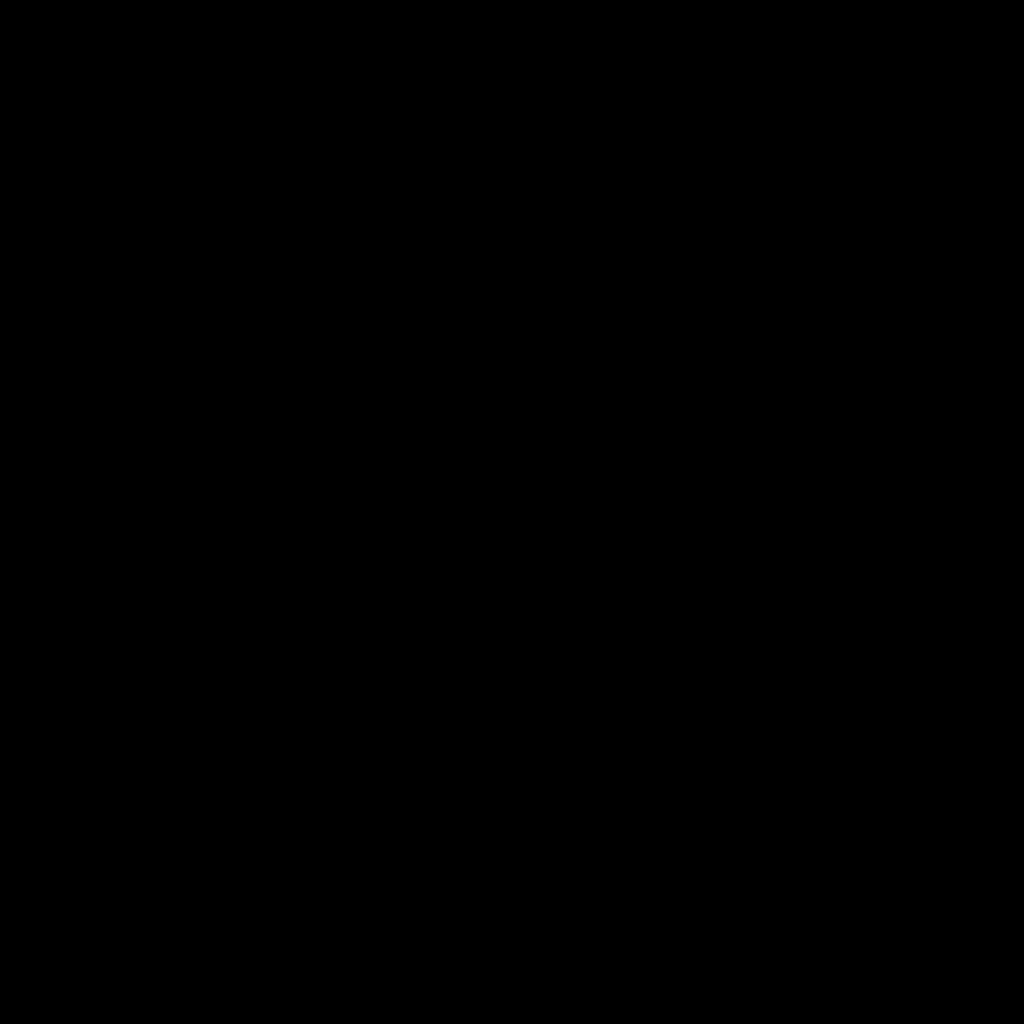

In [5]:
#Now let's see take some subset of our original data from data loader and see what our tissue mask looks like before training!
indices =  [0,1]
subset = torch.utils.data.Subset(TrainingData, indices)
MaskTestData = DataLoader(dataset = subset, batch_size=batch_size, num_workers=4)
sample_image = MaskTestData.dataset[0][0]
predict_segmentation_img(model, sample_image)

In [6]:
def tiss_training_loop(
    model,
    device,
    epochs,
    batch_size:         int = 128,
    learning_rate:      float = 1e-3,
    val_percent:        float = 0.2,
    save_checkpoint:    bool = True,
    amp:                bool = False,
    weight_decay:       float = 1e-3,
    momentum:           float = 0.9,
    gradient_clipping:  float = 1.0
):
    transforms = transf.Compose([transf.ToTensor()])

    #Loading our data, performing necessary splits (update with test set in future), and send to loader
    print("Loading Ocelot dataset...")
    training_data = OcelotDatasetLoader(paths = DATA_PATHS, dataToLoad = 'Tissue', transforms=transforms)
    train_percent = 1 - val_percent
    train_N, val_N = [int(train_percent*len(training_data)), int(val_percent*len(training_data))]
    train_split, val_split = torch.utils.data.random_split(training_data, [train_percent, val_percent])
    train_loader = DataLoader(train_split, batch_size=batch_size, num_workers=4)
    val_loader = DataLoader(val_split, batch_size=batch_size, num_workers=4)  
    print(f"Found {len(training_data)} data samples.")   
    
    #TODO: Initialize logging???
    
    #Initialize optimizer, loss, learning rate, and loss scaling
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=learning_rate,
                                momentum=momentum,
                                weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss() #binary cross entropy w/ logit loss (BCE + softmax)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5) #we use max here as our purpose is to maximize our measured metric (DICE score of 1 is better: more mask similarity)
    grad_scaler = torch.cuda.amp.grad_scaler.GradScaler(enabled=amp) #only for AMP. prevents loss of values due to switch between multiple fp formats
    global_step = 0

    #Begin training
    for epoch in range(1, epochs+1):
        model.train()
        model.to(device)
        
        with tqdm(total=train_N, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch[0], batch[1]
                assert images.shape[1] == model.n_channels, f"Expected {model.n_channels} channels from image but received {images.shape[1]} channels instead."
                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last if amp==True else torch.preserve_format)
                true_masks = true_masks.to(device=device, dtype=torch.float32)

                with torch.autocast(device.type if device.type == 'cuda' else 'cpu', enabled=amp):
                    infer_masks = model(images)
                    loss = criterion(infer_masks, true_masks) #TODO: to squeeze or not to squeeze, that is the question.
                    #TODO: CALC DICE LOSS KERAS?
                    #TODO: loss += dice score

                optimizer.zero_grad() #OPTIONAL: set_to_none=True
                grad_scaler.scale(loss).backward() #scales w/ AMP enabled from loss and backprop
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])

                pass


    return

train = tiss_training_loop(model=model, device=my_device, epochs=10, batch_size=1, amp=False, val_percent=0.2)

Loading Ocelot dataset...
Found 400 data samples.


Epoch 1/10:   9%|▉         | 30/320 [00:52<08:26,  1.75s/img] 


KeyboardInterrupt: 

In [ ]:
print(torch.cuda.memory_reserved(0))
torch.cuda.empty_cache()